In [1]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('housing.csv')

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
df = df[df.ocean_proximity.isin(['<1H OCEAN', 'INLAND'])]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [6]:
df.total_bedrooms=df.total_bedrooms.fillna(0)

In [7]:
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [8]:
df.median_house_value = np.log1p(df.median_house_value)

In [9]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,12.973866,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,12.287657,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,12.419574,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,12.554971,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,12.287196,<1H OCEAN


In [10]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(9411, 3138, 3138)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [13]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

### Question 1

In [14]:
from sklearn.tree import DecisionTreeRegressor

In [15]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [16]:
from sklearn.tree import export_text

In [17]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



#### Answer: ocean_proximity

### Question 2

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [20]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

0.24491083521701304

#### Answer: 0.245

### Question 3

In [23]:
def RFRegressorTuner(n_estimators, max_depth):
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1, max_depth=max_depth)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

In [25]:
arr_n_estimators = np.arange(10, 210, 10)
scores = []
for n in arr_n_estimators:
    scores.append((n, RFRegressorTuner(n, None)))

In [54]:
from matplotlib import pyplot as plt
%matplotlib inline

In [56]:
import importlib
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/home/mogos/miniconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

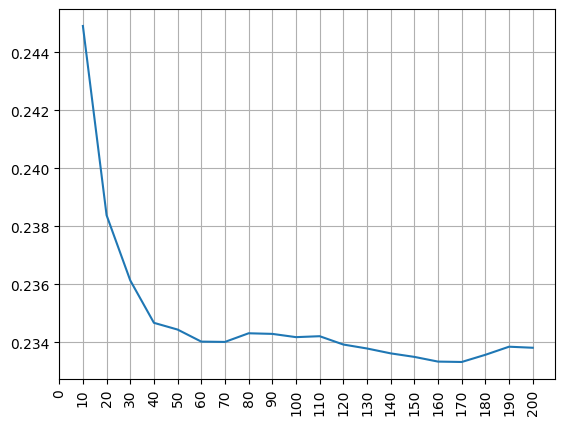

In [65]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
#rmse = round(df_scores.rmse, 3)
plt.plot(df_scores.n_estimators, df_scores.rmse)

plt.xticks(range(0,210,10), rotation='vertical')
plt.grid()

In [66]:
df_scores

,n_estimators,rmse
0,10,0.244911
1,20,0.238384
2,30,0.236135
3,40,0.234671
4,50,0.234439
5,60,0.234023
6,70,0.234013
7,80,0.234311
8,90,0.234290
9,100,0.234178


#### Answer 160

### Question 4

In [67]:
arr_n_estimators = np.arange(10, 210, 10)
arr_max_depth = [10, 15, 20, 25]
final_scores = []
for d in arr_max_depth:
    scores = []
    for n in arr_n_estimators:
        scores.append(RFRegressorTuner(n, d))
    final_scores.append((d, np.mean(scores)))

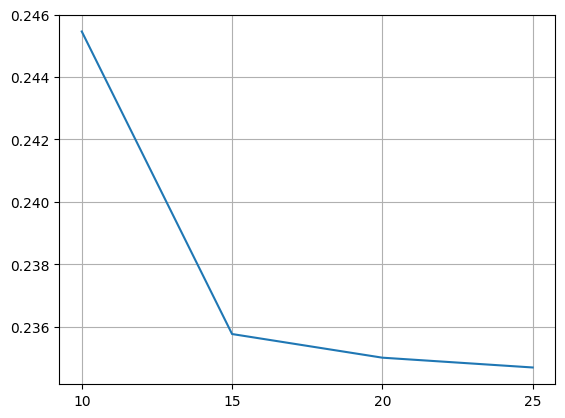

In [69]:
df_scores = pd.DataFrame(final_scores, columns=['max_depth', 'mean_rmse'])
#rmse = round(df_scores.rmse, 3)
plt.plot(df_scores.max_depth, df_scores.mean_rmse)

plt.xticks([10, 15, 20, 25])
plt.grid()

#### Answer: 25

### Question 5

In [74]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1, max_depth=20)
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.01446473, 0.03001848, 0.10249128, 0.08603838, 0.33554034,
       0.21881985, 0.14745955, 0.02827243, 0.01573663, 0.02115832])

In [86]:
df_importance = pd.DataFrame({'feature':dv.feature_names_, 'importance': rf.feature_importances_})
df_importance

,feature,importance
0,households,0.014465
1,housing_median_age,0.030018
2,latitude,0.102491
3,longitude,0.086038
4,median_income,0.335540
5,ocean_proximity=<1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460
7,population,0.028272
8,total_bedrooms,0.015737
9,total_rooms,0.021158


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'households'),
  Text(1, 0, 'housing_median_age'),
  Text(2, 0, 'latitude'),
  Text(3, 0, 'longitude'),
  Text(4, 0, 'median_income'),
  Text(5, 0, 'ocean_proximity=<1H OCEAN'),
  Text(6, 0, 'ocean_proximity=INLAND'),
  Text(7, 0, 'population'),
  Text(8, 0, 'total_bedrooms'),
  Text(9, 0, 'total_rooms')])

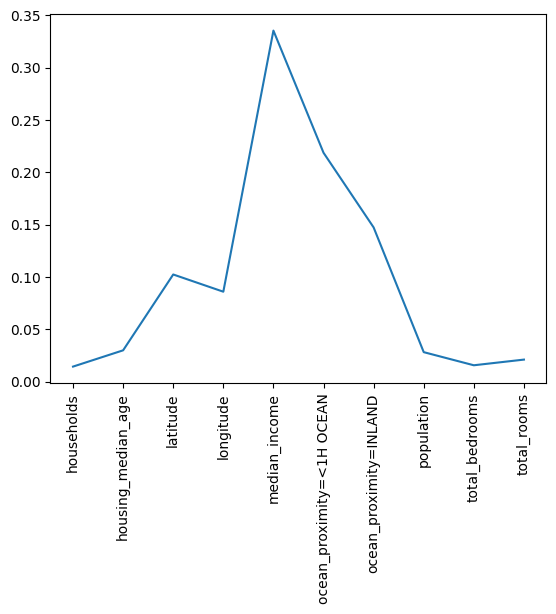

In [88]:
plt.plot(df_importance.feature, df_importance.importance)
plt.xticks(rotation='vertical')

#### Answer: median_income

### Question 6

In [89]:
import xgboost as xgb

In [98]:
dv.feature_names_

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=LE1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [99]:
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [100]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [101]:
y_pred = model.predict(dval)

In [102]:
mean_squared_error(y_val, y_pred, squared=False)

0.228623199980106

In [103]:
xgb_params['eta'] = 0.1
xgb_params

{'eta': 0.1,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'nthread': 8,
 'seed': 1,
 'verbosity': 1}

In [104]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)
mean_squared_error(y_val, y_pred, squared=False)

0.23208927121609343

#### Answer 0.1